In [1]:
import numpy as np; import matplotlib.pyplot as plt 
import seaborn as sns;import pymc3 as pm 
import theano ;import pandas as pd
from theano import shared, tensor as tt

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
import os
cwd = os.chdir("/Users/jackcarter/Documents/Data_Mixtures")
df = pd.read_csv("Tremblay_Data.csv", engine = "python")
temp= df['temp'].values
data = df['data'].values

In [3]:
X = temp + 273.15; qq = data
tplot = 10000/X; N = len(qq)
idx = np.linspace(0, N-1, N).astype(int)

In [4]:
x = X[:, np.newaxis]
data = qq[:, np.newaxis]
N = data.shape[0]
idx = np.linspace(0, N-1, N).astype(int)

# Non-Parametric 

In [5]:
import pymc3.distributions.transforms as tr
Q = pm.Model() 
k = 10
R = 8.314e-3
with Q: 
    
    phi = pm.Dirichlet('phi', 
                     a =  np.ones(k)/k, 
                      testval = np.ones(k)/k)
    
    z = pm.Categorical('z', p = phi, 
                      shape = N)

In [6]:
with Q: 

    # Diffusion Kinetics
    ea = pm.Normal('Ea', mu = 90, sd = 2)
    
    d0 = pm.HalfNormal('D0', sd = 50)
    
    # Grain effective Diffusive lengthscale 
    a = pm.HalfNormal('a', sd = 0.1, 
                   shape = k)
    
    
    # Model
    mu = pm.Deterministic('model', 
                          tt.log(phi[z]**2*(d0/(a[z]**2)) \
                         * tt.exp(-ea/(R \
                                * X[idx]))))

# Normal Mixture Sum of Squares Likelihood

In [7]:
with Q: 
    sd = pm.HalfNormal('sd', sd = 0.01, shape = k)
    obs = pm.Normal('obs', mu, sd = sd[z],
                          observed = qq)
    

In [8]:
for RV in Q.basic_RVs: 
    print(Q.name, Q.logp(Q.test_point))

 -23696829.172683068
 -23696829.172683068
 -23696829.172683068
 -23696829.172683068
 -23696829.172683068
 -23696829.172683068
 -23696829.172683068


In [17]:
with Q: 
    step1 = pm.CategoricalGibbsMetropolis([z])
    step2 = pm.NUTS([ea, d0, a, sd, phi])
    trace = pm.sample(10000, tune = 5000, 
                     step = [step1, step2])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [z]
>NUTS: [phi, sd, a, D0, Ea]
Sampling 2 chains: 100%|██████████| 30000/30000 [5:05:22<00:00,  3.39draws/s]      
There were 2567 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 5081 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.457692417346178, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


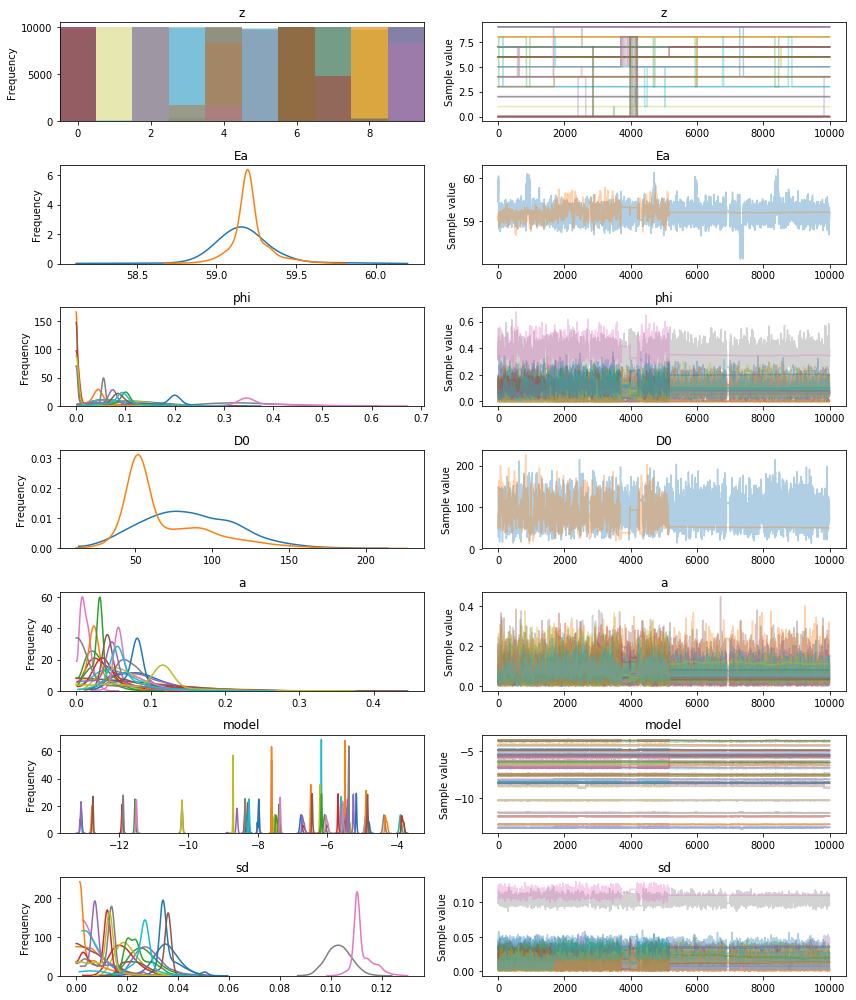

In [18]:
pm.traceplot(trace); 

In [19]:
with Q: 
    ppc = pm.sample_ppc(trace, 1000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 1000/1000 [00:00<00:00, 1021.85it/s]


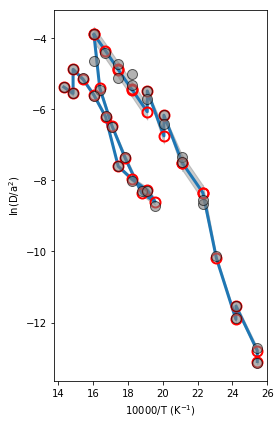

In [20]:
plt.figure(figsize = (4,6))
plt.plot(tplot,ppc['obs'].mean(axis = 0), '-o', 
        markeredgewidth =2 , markeredgecolor = 'r', markerfacecolor = 'None', 
        ms = 10, lw = 3);
#plt.plot(tplot, trace['model'].mean(axis = 0).mean(axis = 0), '-o', 
#        markeredgewidth =2 , markeredgecolor = 'r', 
#         markerfacecolor = 'None', 
#        ms = 10, lw = 3)
plt.plot(tplot,data, 'o', 
          color= 'grey', markeredgecolor = 'k', ms = 10, 
         alpha = 0.6) 
low, high = np.percentile(ppc['obs'], [2.5, 97.5], 
                         axis = 0)
plt.fill_between(tplot, low, high, color = 'grey', 
                alpha = 0.4)
plt.xlabel('10000/T (K$^{-1}$)')
plt.ylabel('ln(D/a$^{2}$)')
plt.tight_layout()
plt.savefig('Tremblay_arrhenius.pdf')

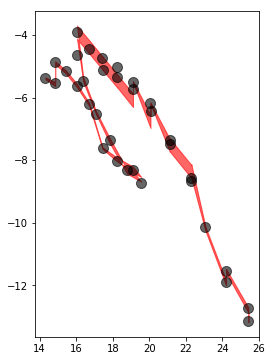

In [21]:
low, high = np.percentile(ppc['obs'], [2.5, 97.5], 
                         axis = 0)
plt.figure(figsize = (4,6))
plt.fill_between(tplot, low, high, color = 'r', 
                alpha = 0.6)
plt.plot(tplot,data, 'o', 
          color= 'k', markeredgecolor = 'k', ms = 10, 
         alpha = 0.6) 

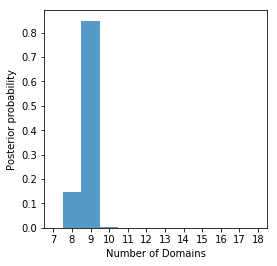

In [25]:
n_domains = np.apply_along_axis(lambda x: np.unique(x).size,
                                1, 
                                trace['z'])
fig, ax = plt.subplots(figsize=(4, 4))

bins = np.arange(0,20)
ax.hist(n_domains + 1, bins=bins, normed=True,
        lw=3, alpha=0.75);


bins = np.arange(n_domains.min(),
                 n_domains.max() + 10)
ax.set_xticks(bins + 0.5);
ax.set_xticklabels(bins);
ax.set_xlim(bins.min(), bins.max() + 1);
ax.set_xlabel('Number of Domains');
#ax.set_ylim(0,0.0001)

ax.set_ylabel('Posterior probability');

# Ln(r/r0) plot

In [15]:
r1 = ppc['obs'].mean(axis = 0)
r0 = qq

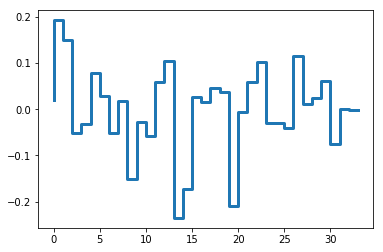

In [16]:
q = 0.5*(r1 - r0)

plt.plot(q, 
        '-', drawstyle = 'steps',
        markeredgecolor = 'k', 
        markeredgewidth = 1.3, 
        markersize  = 9, lw = 3); 

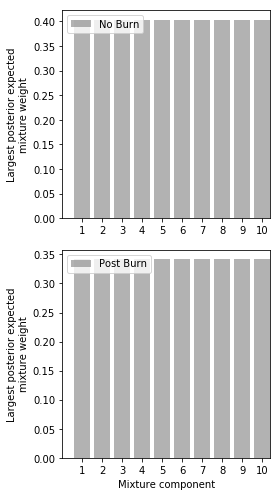

In [62]:
fig, ax = plt.subplots(2,1,figsize = (4,7))
ax[0].bar(np.arange(k) + 1, 
      trace['phi'].mean(axis = 0).max(axis = 0), 
      label = 'No Burn', alpha = 0.6, lw = 2, 
         color = 'grey'); 

ax[1].bar(np.arange(k) + 1, 
      trace['phi'][-10000::2].mean(axis = 0).max(axis = 0), 
      label = 'Post Burn', lw = 2, alpha = 0.6, 
         color = 'grey')
ax[0].set_xticks(np.arange(0, k, 1) + 1); 
ax[0].legend()
ax[0].set_xlim(0, 10 + 0.4)
ax[0].set_ylabel('Largest posterior expected\nmixture weight')



ax[1].set_xticks(np.arange(0, k, 1) + 1); 
ax[1].legend()
ax[1].set_xlim(0, 10 + 0.4)
ax[1].set_xlabel('Mixture component')
ax[1].set_ylabel('Largest posterior expected\nmixture weight')



plt.tight_layout()

In [ ]:
plt.plot(trace['w'].mean(axis = 0));

In [306]:
ml = Q.logp
logp = [ml(i) for i in trace]

plt.plot(logp)

KeyboardInterrupt: 

In [ ]:
tr_a = approx.sample(1000)
plt.traceplot(tr_a); 

# Plotting Phi Estimates

In [ ]:
def plot_phi_estimates(trace): 
    for j in range(k):
        sns.distplot(trace['phi'][:, j], kde = True, 
                    hist = False, kde_kws ={"lw":2})
        plt.xlim(0,trace['phi'].max() + 0.1)
        

In [ ]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 13}
plt.rc('font', **font)

#### Phi ######
plt.figure(figsize = (4,4)); 
plot_phi_estimates(trace[-600:]); 
plt.xlabel('$\phi$'); 
plt.ylabel('Probability  Density'); 
plt.tight_layout()
plt.savefig('tremblay_model4.pdf')

# Plotting Grain Radii Estimates

In [ ]:
def plot_a_estimates(trace): 
    for j in range(k):
        sns.distplot(trace['a'][:, j], kde = True, 
                    hist = False, kde_kws ={"lw":2})
        plt.xlim(0,trace['a'].max() + 0.0005)

In [ ]:
#### a ######
plt.figure(figsize = (4,4)); 
plot_a_estimates(trace); 
plt.xlabel('$a$'); 
plt.ylabel('Probability  Density'); 
plt.ylim(0, 500)

# Plot Activation Energy Estimates 

In [259]:
def plot_Ea_estimates(trace): 
    for j in range(k):
        sns.distplot(trace['Ea'][:, j], kde = True, 
                    hist = False, kde_kws ={"lw":2})
        plt.xlim(trace['Ea'].min() - 6,trace['Ea'].max() + 5)
        plt.ylim(0,0.7)

In [260]:
#### Ea ######
plt.figure(figsize = (4,4)); 
plot_Ea_estimates(trace); 
plt.xlabel('$E_a$'); 
plt.ylabel('Probability  Density'); 

IndexError: too many indices for array

<Figure size 320x320 with 0 Axes>

# Plot Frequency Factor Estimates 

In [261]:
def plot_D0_estimates(trace): 
    for j in range(k):
        sns.distplot(trace['D0'][:, j], kde = True, 
                    hist = False, kde_kws ={"lw":2})
        plt.xlim(trace['D0'].min() - 6,trace['D0'].max() + 5)
        plt.ylim(0,0.7)

In [262]:
#### D0 ######
plt.figure(figsize = (4,4)); 
plot_D0_estimates(trace); 
plt.xlabel('$D_0$'); 
plt.ylabel('Probability  Density'); 

IndexError: too many indices for array

<Figure size 320x320 with 0 Axes>